In [1]:
import os
import pandas as pd
import pylab as pl
import numpy as np
import re
from sklearn.model_selection import train_test_split, KFold

# 1.Read CSV File Into Python

In [11]:
#covert a string that is camelcase into snake_case
def camel_to_snake(column_name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def read(file_name):
    if not os.path.isfile(file_name):
        raise ValueError('File Not Found')
        
    ext = file_name.split('.')[-1].lower()
    if 'csv' == ext:
        df = pd.read_csv(file_name)
    elif 'xls' in ext:
        df = pd.read_excel(file_name)
    elif 'json' == ext:
        df = pd.read_json(file_name)
    else:
        raise ValueError('Only support csv, xls and json')

    return df

In [12]:
df = pd.read_csv('./credit-data.csv')

In [26]:
# convert each column name to snake case
df.columns = [camel_to_snake(col) for col in df.columns]
df.head()

,person_id,serious_dlqin2yrs,revolving_utilization_of_unsecured_lines,age,zipcode,number_of_time30-59_days_past_due_not_worse,debt_ratio,monthly_income,number_of_open_credit_lines_and_loans,number_of_times90_days_late,number_real_estate_loans_or_lines,number_of_time60-89_days_past_due_not_worse,number_of_dependents
0,98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,0,0.0
1,98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,0,0.0
2,99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,0,0.0
3,99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,0,0.0
4,99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,0,2.0


# 2.Data Exploration

## 2.1 Basic info

In [69]:
label_name = 'serious_dlqin2yrs'
feature_names = [name for name in df.columns if name != label_name]
df.count()

person_id                                      38911
serious_dlqin2yrs                              38911
revolving_utilization_of_unsecured_lines       38911
age                                            38911
zipcode                                        38911
number_of_time30-59_days_past_due_not_worse    38911
debt_ratio                                     38911
monthly_income                                 38911
number_of_open_credit_lines_and_loans          38911
number_of_times90_days_late                    38911
number_real_estate_loans_or_lines              38911
number_of_time60-89_days_past_due_not_worse    38911
number_of_dependents                           38911
dtype: int64

In [70]:
#figure out which variables contain null values. First, melt our data into long format.print a table telling the no of null and non-null instances.
df_lng = pd.melt(df)
null_variables = df_lng.value.isnull()
pd.crosstab(df_lng.variable, null_variables)

value,False
variable,
age,38911
debt_ratio,38911
monthly_income,38911
number_of_dependents,38911
number_of_open_credit_lines_and_loans,38911
number_of_time30-59_days_past_due_not_worse,38911
number_of_time60-89_days_past_due_not_worse,38911
number_of_times90_days_late,38911
number_real_estate_loans_or_lines,38911


## 2.2 Correlations between features vs label

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

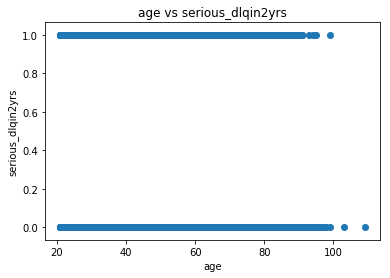

In [8]:
plt.scatter(df['age'], df['serious_dlqin2yrs'])
plt.title('age vs serious_dlqin2yrs')
plt.xlabel('age') 
plt.ylabel('serious_dlqin2yrs')
plt.show()

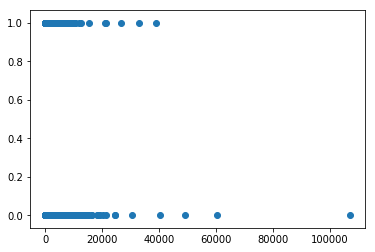

In [9]:
plt.scatter(df['debt_ratio'], df['serious_dlqin2yrs'])
plt.show()

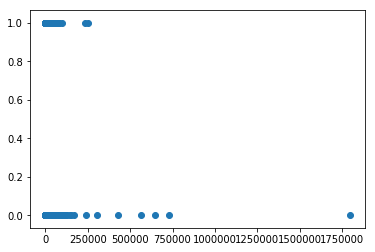

In [10]:
plt.scatter(df['monthly_income'], df['serious_dlqin2yrs'])
plt.show()

we can find that the output seriousdlqin2yrs only takes on value 1 or 0 for every variable.

## 2.3 Plot value frequency to see value distribution

plot graphs of these features.


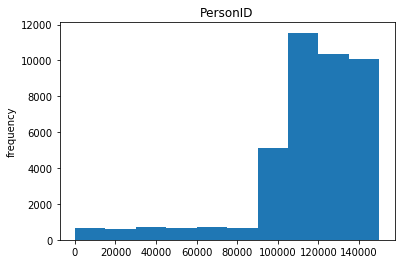

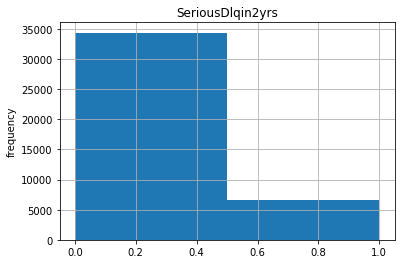

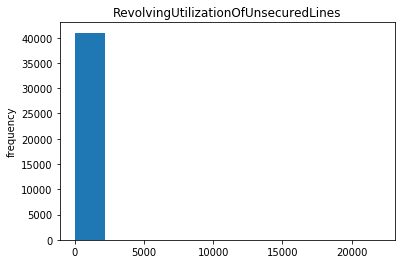

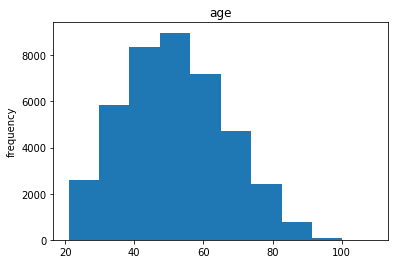

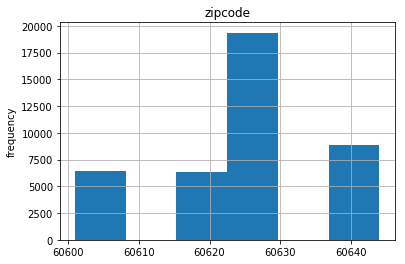

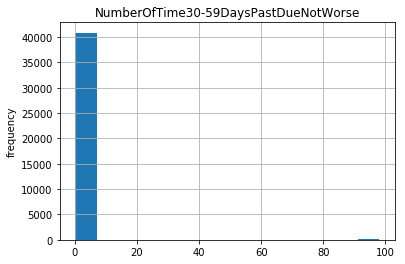

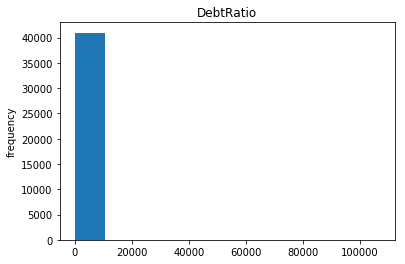

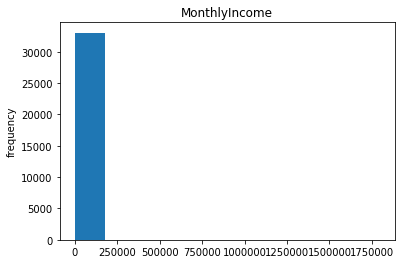

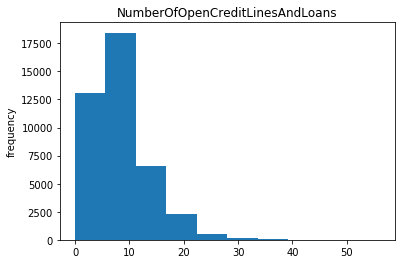

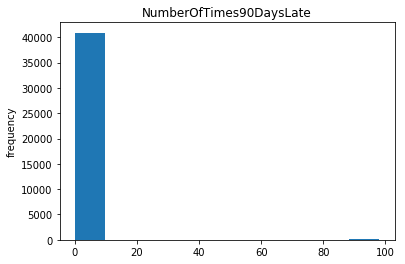

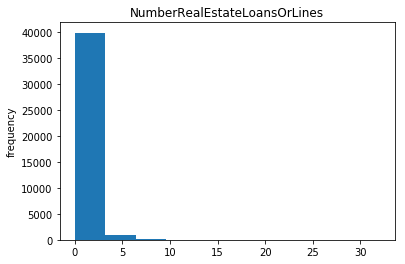

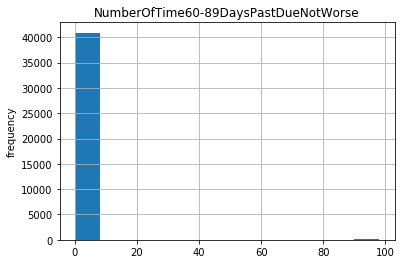

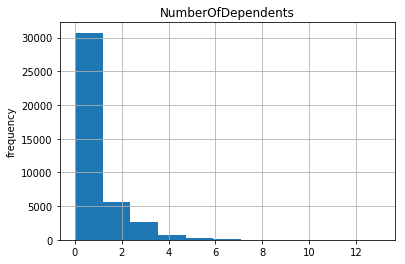

In [15]:
def plot_features(df):
    print('plot graphs of these features.')
    for feature in df.keys():
        plt.clf()
        unique_vals = len(df[feature].value_counts())
        if unique_vals == 1:
            df.groupby(feature).size().plot(kind='bar')
        elif unique_vals < 15:
            bins = unique_vals
            df[feature].hist(bins=unique_vals)
        else:
            df[feature].plot.hist()
        plt.ylabel('frequency')
        plt.title(feature)
        plt.show()
        
        
plot_features(df)

As we can see, number_of times90_days_late, numbers_real_estate_loans_or lines and etc features have uneven distribution.

## 2.4 Find outliers

In [67]:
df.describe()

,person_id,serious_dlqin2yrs,revolving_utilization_of_unsecured_lines,age,zipcode,number_of_time30-59_days_past_due_not_worse,debt_ratio,monthly_income,number_of_open_credit_lines_and_loans,number_of_times90_days_late,number_real_estate_loans_or_lines,number_of_time60-89_days_past_due_not_worse,number_of_dependents
count,38911.000000,38911.000000,38911.000000,38911.000000,38911.000000,38911.000000,38911.000000,3.891100e+04,38911.000000,38911.000000,38911.000000,38911.000000,38911.000000
mean,115747.251548,0.162628,5.482370,51.595718,2.185140,0.602195,124.621880,6.594889e+03,8.283082,0.436715,0.961245,0.386574,0.784746
std,28198.564993,0.369030,204.617517,14.918288,1.441342,5.340119,404.690976,1.238704e+04,5.180060,5.326922,1.127876,5.306361,1.111886
min,22.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,106484.500000,0.000000,0.033629,40.000000,1.000000,0.000000,0.166137,3.700000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,119909.000000,0.000000,0.187200,51.000000,2.000000,0.000000,0.347264,6.100000e+03,7.000000,0.000000,1.000000,0.000000,0.000000
75%,134725.500000,0.000000,0.671681,62.000000,3.000000,0.000000,0.687842,7.500000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,149999.000000,1.000000,22000.000000,109.000000,5.000000,98.000000,2299.000000,1.794060e+06,56.000000,98.000000,32.000000,98.000000,13.000000


In [74]:
def find_outliers(df, col):
    return df[((df[col] - df[col].mean()) / df[col].std()).abs() >= 3]

def find_all_outliers(df):
    for f in feature_names:
        print(f, ' outliers rows:', len(find_outliers(df, f)))
        
find_all_outliers(df)

person_id  outliers rows: 1257
revolving_utilization_of_unsecured_lines  outliers rows: 54
age  outliers rows: 12
zipcode  outliers rows: 0
number_of_time30-59_days_past_due_not_worse  outliers rows: 114
debt_ratio  outliers rows: 1646
monthly_income  outliers rows: 105
number_of_open_credit_lines_and_loans  outliers rows: 479
number_of_times90_days_late  outliers rows: 115
number_real_estate_loans_or_lines  outliers rows: 397
number_of_time60-89_days_past_due_not_worse  outliers rows: 114
number_of_dependents  outliers rows: 265


**As we can see, debt_ratio has the most outliers**

# 3.Data Preprocess

In [17]:
#create a pivot table
df_lng.head()

,variable,value
0,person_id,1.0
1,person_id,2.0
2,person_id,3.0
3,person_id,4.0
4,person_id,5.0


In [19]:
df_lng = pd.melt(df)
null_variables = df_lng.value.isnull()
df_lng.head()
pd.crosstab(df_lng.variable, null_variables)

value,False,True
variable,,
DebtRatio,41016,0
MonthlyIncome,33042,7974
NumberOfDependents,39979,1037
NumberOfOpenCreditLinesAndLoans,41016,0
NumberOfTime30-59DaysPastDueNotWorse,41016,0
NumberOfTime60-89DaysPastDueNotWorse,41016,0
NumberOfTimes90DaysLate,41016,0
NumberRealEstateLoansOrLines,41016,0
PersonID,41016,0


We can see that monthly income and numbers of dependents have missing values.Next is to replace the missing values.

## 3.1 Check missing values

In [21]:
def check_missing(df):
    return [col for col in df.columns if any(df[col].isnull()) == True]

def fill_missing(df, col_name, method):
    if method == 'mean':
        df[col_name] = df[col_name].fillna(df[col_name].mean())
    elif method == 'median':
        df[col_name] = df[col_name].fillna(df[col_name].median())
    elif method == 'zero':
        df[col_name] = df[col_name].fillna(0)
        
missing_cols = check_missing(df)
missing_cols

['MonthlyIncome', 'NumberOfDependents']

## 3.2 Fill out missing values by "mean" value

In [23]:
for col in missing_cols:
    fill_missing(df, col, 'mean')
check_missing(df)

[]

## 3.3 Drop out outliers

In [29]:
# use (data - mean) < 3 * std to determine whether to drop
def drop_outliers(df, col):
    return df[((df[col] - df[col].mean()) / df[col].std()).abs() < 3]
features = ['debt_ratio']
old_len = len(df)
for f in features:
    df = drop_outliers(df, f)

print('drop out {} outliers'.format(old_len - len(df)))

drop out 1504 outliers


# 4.Generate Features

## 4.1 Category features

In [35]:
# encode zipcode by unique number idx
df['zipcode'] = df['zipcode'].astype('category').cat.codes
df[['zipcode', 'age']].groupby('zipcode').count()

,age
zipcode,
0,6084
1,5997
2,12283
3,6136
4,6000
5,2411


## 4.2 Use DT to sort features importance

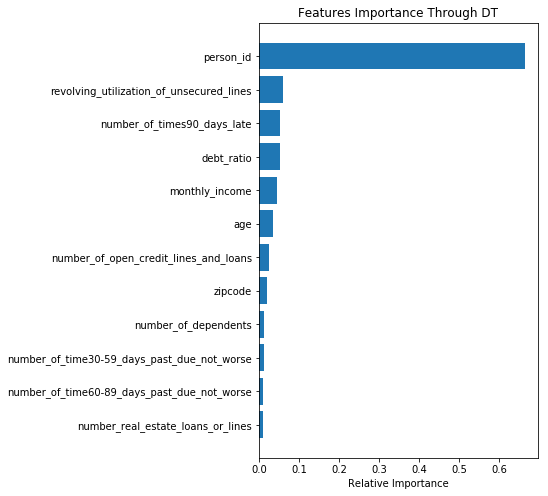

In [36]:
from sklearn.tree import DecisionTreeClassifier


def sort_features_through_dt(df_features, df_label):
    features = df_features.columns
    model = DecisionTreeClassifier()
    model.fit(df_features, df_label)
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)
    padding = np.arange(len(features)) + 0.5
    plt.figure(figsize=(5, 8))
    plt.barh(padding, importances[sorted_idx], align='center')
    plt.yticks(padding, np.asarray(features)[sorted_idx])
    plt.xlabel("Relative Importance")
    plt.title("Features Importance Through DT")
    
    return list(np.asarray(features)[sorted_idx][::-1])


df_features, df_label = df[feature_names], df[label_name]

# sort all the features by importance
sorted_features = sort_features_through_dt(df_features, df_label)

## 4.3 Select Top 2/3 features

In [37]:
# Select top 2/3 features
count = int(len(sorted_features) * 0.67)
df_features = df_features[sorted_features[:count]]
df_features.head()

,person_id,revolving_utilization_of_unsecured_lines,number_of_times90_days_late,debt_ratio,monthly_income,age,number_of_open_credit_lines_and_loans,zipcode
0,98976,1.000000,0,505.000000,0.0,55,2,0
1,98991,0.547745,0,0.459565,15666.0,71,7,0
2,99012,0.044280,0,0.014520,4200.0,51,5,0
3,99023,0.914249,0,0.794875,9052.0,55,12,0
4,99027,0.026599,0,0.049966,10406.0,45,4,0


# 5.Build Classifier

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_recall_curve, roc_auc_score, roc_curve, auc,
                             precision_score, recall_score, f1_score)

## 5.1 Split the data

In [54]:
from sklearn.model_selection import train_test_split
df_target = df['serious_dlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2)

## 5.2 Find best params for LR

In [57]:
def build_clf(X_train, y_train):
    params = {'penalty': ['l1', 'l2'], 'C': [10 ** i for i in range(-5, 2)]}
    clf = GridSearchCV(LogisticRegression(), params, cv=5)
    clf.fit(X_train, y_train)
    print('LR best params: %s, best score: %.4f' % (clf.best_params_, clf.best_score_))    
    return clf

    
classifier = build_clf(X_train, y_train)

LR best params: {'C': 1, 'penalty': 'l1'}, best score: 0.9299


# 6.Evaluation classifer

## 6.1 Calculate f1, auc, recall and precision

In [61]:
# evalute metrics
def evaluate_classifier(y_test, y_pre, y_prob):
    return {
        'precision': float("%.4f" % precision_score(y_test, y_pre)),
        'recall': float("%.4f" % recall_score(y_test, y_pre)),
        'f1': float("%.4f" % f1_score(y_test, y_pre)),
        'auc': float("%.4f" % roc_auc_score(y_test, y_prob))
    }

y_pre = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:, 1]
metrics = evaluate_classifier(y_test, y_pre, y_prob)
metrics

{'auc': 0.8452, 'f1': 0.7257, 'precision': 0.9919, 'recall': 0.5721}

## 6.2 Draw Auc

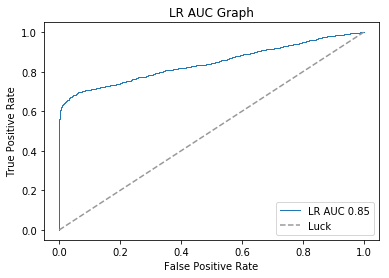

In [64]:
def draw_auc(y_prob, y_test):
    plt.clf()
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=1, label=('LR AUC %.2f' % roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LR AUC Graph')
    plt.legend(loc="lower right")

draw_auc(y_prob, y_test)

the AUC is close to 1, which means the classifier is good.